# Grover's algorithm

## Overview

- **Type:** Query algorithm
- **Time complexity:** $O(\sqrt{N})$ queries, where $N$ is the size of the search space
- **Advantage:** Quadratic speed-up over classical algorithms
- **Approachability:** Medium
- **Related topics:** Amplitude amplification

Grover's algorithm is a quantum query algorithm for searching an unstructured (or unordered) search space.
It has a provable quadratic speedup over classical algorithms.
As it ignores any problem structure, Grover's algorithm is widely applicable but often less efficient than problem-specific algorithms.

The method used by Grover's algorithm was generalized into _amplitude amplification_, which appears in several other quantum algorithms, particularly query problems.

This page should be understandable to anyone comfortable with basic quantum computing concepts.

## Problem statement

Grover's algorithm solves the classical _unstructured search_ problem.

> **Unstructured search:** The input is a function of the form $f:\{0,1\}^n \rightarrow \{0,1\}.$
> The goal is to find a binary string $x$ for which $f(x) = 1$, or report that there is no such string.

The function $f$ is sometimes called the _oracle_ function. To implement Grover's algorithm as a quantum circuit, the function $f$ must be converted to a quantum circuit $Z_f$ such that

$$
Z_f |x\rangle = \bigg\{\begin{aligned}\phantom{-}|x\rangle \quad \text{if} \; f(x)=0 \\
   -|x\rangle \quad \text{if} \; f(x)=1 \\\end{aligned}
$$

We'll also refer to $Z_f$ as the _oracle_, or sometimes a _phase oracle_, as it changes amplitude phase. See the [phase oracles page](#) for examples of converting problems to this form.

## Algorithm

### High-level description

Grover's algorithm uses an $n$-qubit quantum register $\mathsf{X}$.

1. *Initialization*. Prepare the qubits in an equal superposition of all possible states. We'll call this quantum state $|s\rangle$, and you can create it from the all-zeros state by applying a Hadamard gate to each qubit in $\mathsf{X}$.

   $$|s\rangle = H^{\otimes n}|00\cdots0\rangle$$

2. *Iterate*. Repeat the following steps $t$ times (where $t$ is chosen as discussed in [analysis](#)):

   2.1 Apply the $Z_f$ operation to the register $\mathsf{X}$.
   
   $$
   Z_f |x\rangle = \bigg\{\begin{aligned}\phantom{-}|x\rangle \quad \text{if} \; f(x)=0 \\
   -|x\rangle \quad \text{if} \; f(x)=1 \\\end{aligned}
   $$
   
   2.2 Apply the diffuser $D_s$ to the qubits. The diffuser is a reflection around $|s\rangle$:

   $$ D_s = 2|s\rangle\langle s| - \mathbb{1} $$

3. Measure the qubits in the standard basis. 

The result of the measurements can be interpreted as a guess for a string $x$ for which $f(x)=1.$
The oracle can be used one final time after $x$ is measured to check the solution — outputting $x$ if $f(x) = 1$ and outputting "no solution found" if $f(x) = 0.$

Note that we query the oracle in step 2.1, so the total number of queries is equal to the number of iterations of step 2 (plus one if we use the oracle to check the answer).

## Qiskit implementation

### Phase oracle

Grover's algorithm takes a _phase oracle_ as input, which is a quantum operation of the following form

$$
Z_f |x\rangle = \bigg\{\begin{aligned}\phantom{-}|x\rangle \quad \text{if} \; f(x)=0 \\
   -|x\rangle \quad \text{if} \; f(x)=1 \\\end{aligned}
$$

The following code cell creates a unitary for $Z_f$ based on some predetermined "good states", which are the states for which $Z_f|x\rangle = -|x\rangle$. See the [phase oracles page](#) for examples of converting real problems to phase oracle circuits.

(TODO: find a complicated circuit for $Z_f$ to show that it's not always easy to see "good states" beforehand)

In [1]:
NUM_QUBITS = 4
good_states = ["0010"]

# Create an identity matrix (a unitary that does nothing)
from numpy import identity

oracle = identity(2**NUM_QUBITS, dtype=int)

# Alter matrix to mark "good" states
for state in good_states:
    INDEX = int(state, 2)  # Convert bit string to int
    oracle[INDEX][INDEX] = -1

print(f"Oracle matrix:\n{oracle}")

Oracle matrix:
[[ 1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1]]


### Diffuser

Next, we'll create a diffuser circuit. The diffuser is a reflection around $|s\rangle$, which means it must invert the sign of all states perpendicular to $|s\rangle$.

We can create a diffuser from a multi-controlled-Z (MCZ) gate. The MCZ gate is a reflection around the all-ones state ($|1\rangle$), up to a global phase.

$$ \operatorname{MCZ} = \mathbb{1} - 2|1\rangle\langle 1|$$

Since $H^{\otimes n}X^{\otimes n}|1\rangle = |s\rangle$, we can map the CZ gate to a diffuser by wrapping it in H gates and X gates.

$$
\begin{aligned}
H^{\otimes n}X^{\otimes n}(MCZ)X^{\otimes n}H^{\otimes n}
&= H^{\otimes n}X^{\otimes n}(\mathbb{1} - 2|1\rangle\langle 1|) X^{\otimes n}H^{\otimes n} \\
&= \mathbb{1} - 2|s\rangle\langle s| \\
&= -U_s
\end{aligned}
$$

The following code cell creates a diffuser from a MCZ gate.

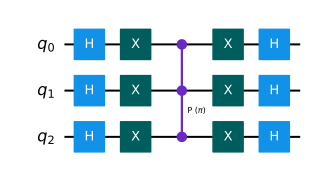

In [2]:
from qiskit import QuantumCircuit
from numpy import pi


def get_diffuser(num_qubits):
    """Creates a diffuser circuit for Grover's algorithm.
    Args:
        num_qubits (int): the number of qubits the diffuser should act on
    Returns:
        QuantumCircuit that implements the diffuser operation
    """
    qc = QuantumCircuit(num_qubits, name="Diffuser")
    qc.h(range(num_qubits))
    qc.x(range(num_qubits))
    qc.mcp(  # multi-controlled-phase gate
        pi,  # rotation angle (equivalent to Z-gate)
        list(range(num_qubits - 1)),  # control qubits
        [num_qubits - 1],  # target qubit
    )
    qc.x(range(num_qubits))
    qc.h(range(num_qubits))
    return qc


get_diffuser(3).draw()

### Full algorithm

The following code defines a circuit for Grover's algorithm using the oracle and diffuser defined earlier.

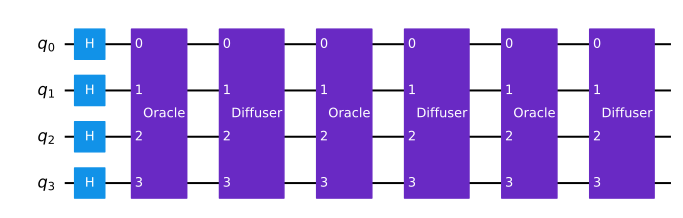

In [3]:
from qiskit import QuantumCircuit

NUM_ITERATIONS = 3

qc = QuantumCircuit(NUM_QUBITS)
qc.h(range(NUM_QUBITS))
for i in range(NUM_ITERATIONS):
    qc.unitary(oracle, range(NUM_QUBITS), label="Oracle")
    qc.append(get_diffuser(NUM_QUBITS), range(NUM_QUBITS))

qc.draw()

The next code cell uses Qiskit's `Statevector` class to simulate the results of running this circuit 1024 times.

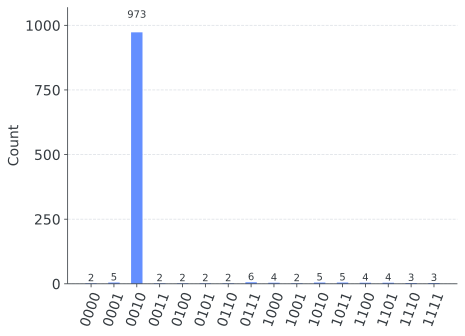

In [6]:
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram

ket_0 = Statevector.from_label("0" * NUM_QUBITS)
ket_psi = ket_0.evolve(qc)
plot_histogram(ket_psi.sample_counts(1024))

## Analysis

For this analysis, we will assume there is only one string $x$ for which $f(x) = 1$. You can adapt this analysis to account for many strings by dividing the search space $N$ by the number of strings for which $f(x) = 1$.

### Classical solution

For completely unstructured problems (in which we have no information about which states are likely to be good), the best algorithm is _random guessing_. This algorithm selects bit strings at random and queries $f$ to see whether that bit string outputs 1. This algorithm requires $N/2$ queries on average.

### Grover's algorithm performance

Grover's algorithm requires ~$O(\sqrt{N})$ queries.

(Include this [geometric proof](https://learn.qiskit.org/course/introduction/grovers-search-algorithm#grovers-19-0) when carousel widget is available).

### Using structure

Most real-world problems are not fully unstructured. That is, we know something about the oracle that helps us make better guesses. (TODO: expand).

## Links

Grover's algorithm was first published in the following paper.

- Lov K. Grover. 1996. _"A fast quantum mechanical algorithm for database search."_ <https://arxiv.org/abs/quant-ph/9605043>

### Further learning

Check out these links to learn about Grover's algorithm in more detail.

- (TODO: link other explanations)


### Later developments

Read later research that builds on Grover's algorithm.

- amplitude amplification
- quantum counting

- N. J. Cerf, L. K. Grover, C. P. Williams. 1998. _"Nested quantum search and NP-complete problems"_ <https://arxiv.org/abs/quant-ph/9806078>

  This paper extends the methods of Grover's algorithm to use some problem structure.

In [5]:
import qiskit.tools.jupyter

%qiskit_version_table